In [1]:
import pandas as pd 
import json
import matplotlib.pyplot as plt
import networkx as nx
import re

DATA_DIR = '/content/jupyter/mta-accessibility/'

In [2]:
elevators = pd.read_csv(DATA_DIR+'data/interim/crosswalks/EE_master_list.csv')
# discard escalators
elevators = elevators[ (elevators.equipment_type == 'EL') & (elevators.is_active == 'Y') ] # & (elevators.ada_compliant == 'Y')
# discard columns we don't need
elevators = elevators[["station_name", "equipment_id", "description", "connection_to_street"]]
elevators.head(25)

,station_name,equipment_id,description,connection_to_street
0,125 St,EL125,125 St & Lexington Ave (NE corner) to Mezzanin...,Y
1,125 St,EL142,125 St & St Nicholas Ave (SW corner) to Mezzan...,Y
2,125 St,EL143,Mezzanine to downtown Platform,N
3,125 St,EL126,Mezzanine to Platforms for service in both dir...,N
4,125 St,EL144,Mezzanine to uptown Platform,N
8,135 St,EL180,Lenox Ave & 181 St (NE corner) to uptown Platform,N
9,135 St,EL181,Lenox Ave & 181 St (SW corner) to downtown Pla...,N
10,14 St - 8 Av,EL221,8th Ave & 14 St (SW corner) to Mezzanine for s...,N
11,14 St - 8 Av,EL222,Mezzanine to downtown A/C/E Platform,N
12,14 St - 8 Av,EL223,Mezzanine to uptown A/C/E Platform,N


In [3]:
mapped_elevators = pd.read_csv(DATA_DIR+'data/processed/elevator_to_line_dir_station.csv')
mapped_elevators.head()

,Unnamed: 0,equipment_id,line,direction,station
0,230,EL103,1,south,191 St
1,21,EL103,1,north,191 St
2,185,EL122,6,manhattan,Pelham Bay Park
3,18,EL124,A,north,175 St
4,628,EL126,5,south,125 St


In [4]:
# the MTA direction information is incomplete!
platform_ids = mapped_elevators[['equipment_id', 'line', 'direction']].set_index('equipment_id')
platform_ids = platform_ids.apply(lambda t : '-'.join(t), axis=1).groupby(level=0).unique()
platform_ids = platform_ids.apply(lambda t : '/'.join(t))
elevators.set_index('equipment_id', inplace=True)
elevators['platform_id'] = platform_ids
elevators.reset_index(inplace=True)
elevators.head()

,equipment_id,station_name,description,connection_to_street,platform_id
0,EL125,125 St,125 St & Lexington Ave (NE corner) to Mezzanin...,Y,NaN
1,EL142,125 St,125 St & St Nicholas Ave (SW corner) to Mezzan...,Y,NaN
2,EL143,125 St,Mezzanine to downtown Platform,N,A-south/D-south/B-south/C-south
3,EL126,125 St,Mezzanine to Platforms for service in both dir...,N,5-south/4-north/5-north/METRO-NORTH-south/METR...
4,EL144,125 St,Mezzanine to uptown Platform,N,C-north/B-north/A-north/D-north


In [5]:
def elevator_route(desc):
    def simplify(name):
        if re.match(r'.*[Pp]latform.*', name):
            return 'Platform'
        if re.match(r'.*(St|Av|Plaza|Blvd|Park|Sidewalk|Pl|Rd|Square).*', name):
            return 'Street'
        if re.match(r'.*Upper Mezzanine.*', name):
            return 'Upper Mezzanine'
        if re.match(r'.*Lower Mezzanine.*', name):
            return 'Lower Mezzanine'
        if re.match(r'.*(Mezzanine|[Bb]alcony).*', name):
            return 'Mezzanine'
        if name in ['PA Bus Terminal', 'Oculus Main Level']:
            return 'Street'
        return 'Unknown'

    # try "to" and "for" first
    m = re.search(r'^(.*?) (to|for) (.*)$', desc)
    if m:
        return simplify(m.group(1)), simplify(m.group(3))
    # then try for "and"
    m = re.search(r'^(.*?) (and) (.*)$', desc)
    if m:
        return simplify(m.group(1)), simplify(m.group(3))

    if re.match('^Mezzanine .*bound Platform$', desc):
        return ('Mezzanine', 'Platform')
    
    return ('Unknown', 'Unknown')

assert elevator_route('125 St & Lexington Ave to Mezzanine for service in both directions') == ('Street', 'Mezzanine')
assert elevator_route('Mezzanine to Platform for downtown A/C service') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to Platforms for service in both directions') == ('Mezzanine', 'Platform')
assert elevator_route('Mezzanine to uptown Platform') == ('Mezzanine', 'Platform')
assert elevator_route('161 St & River Ave (NE Corner) to Mezzanine to reach service in both directions') == ('Street', 'Mezzanine')
assert elevator_route('Street to # 6 Northbound platform') == ('Street', 'Platform')
assert elevator_route('Sidewalk entrance (east of the pedestrian skybridge) to Manhattan bound Platform') == ('Street', 'Platform')
assert elevator_route('G and 7 Mezzanines to Flushing-bound 7 Platform') == ('Mezzanine', 'Platform')

elevators['from'] = elevators.description.apply(lambda d : elevator_route(d)[0])
elevators['to'] = elevators.description.apply(lambda d : elevator_route(d)[1])
# some elevators record the street part explicitly
elevators.loc[elevators['connection_to_street'] == 'Y', 'from'] = 'Street'
elevators.head()



,equipment_id,station_name,description,connection_to_street,platform_id,from,to
0,EL125,125 St,125 St & Lexington Ave (NE corner) to Mezzanin...,Y,NaN,Street,Mezzanine
1,EL142,125 St,125 St & St Nicholas Ave (SW corner) to Mezzan...,Y,NaN,Street,Mezzanine
2,EL143,125 St,Mezzanine to downtown Platform,N,A-south/D-south/B-south/C-south,Mezzanine,Platform
3,EL126,125 St,Mezzanine to Platforms for service in both dir...,N,5-south/4-north/5-north/METRO-NORTH-south/METR...,Mezzanine,Platform
4,EL144,125 St,Mezzanine to uptown Platform,N,C-north/B-north/A-north/D-north,Mezzanine,Platform


In [6]:
# Merge in the override data
override_elevators = pd.read_csv(DATA_DIR+'data/raw/elevator-override.csv')

# discard any old data for elevators described in the override file
elevators = elevators[~elevators.equipment_id.isin(override_elevators.equipment_id.unique())] 
# now append the overrides
elevators = elevators.append(override_elevators, sort=True)

override_elevators.head()

,station_name,equipment_id,from,to,platform_id
0,Howard Beach,EL491X,Street,Mezzanine,NaN
1,Howard Beach,EL490X,Street,Mezzanine,NaN
2,Howard Beach,EL495X,Mezzanine,Platform,A-north
3,Howard Beach,EL494X,Mezzanine,Platform,A-north
4,Howard Beach,EL493X,Mezzanine,Platform,A-south


In [7]:
def make_canon(t):
    label, station, platform_id = t
    if label == 'Unknown':
        return 'Unknown-' + station
    if label == 'Platform':
        return '-'.join([str(x) for x in [label, station, platform_id]])
    return '-'.join([str(x) for x in [label, station]])

elevators['fqn_from'] = elevators[['from', 'station_name', 'platform_id']].apply(make_canon, axis=1)
elevators['fqn_to'] = elevators[['to', 'station_name', 'platform_id']].apply(make_canon, axis=1)
elevators['label_from'] = elevators[['from', 'station_name']].apply(lambda t : t[1] if t[0] == 'Street' else t[0], axis=1)
elevators['label_to'] = elevators['to']
elevators.head()

,connection_to_street,description,equipment_id,from,platform_id,station_name,to,fqn_from,fqn_to,label_from,label_to
0,Y,125 St & Lexington Ave (NE corner) to Mezzanin...,EL125,Street,NaN,125 St,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
1,Y,125 St & St Nicholas Ave (SW corner) to Mezzan...,EL142,Street,NaN,125 St,Mezzanine,Street-125 St,Mezzanine-125 St,125 St,Mezzanine
2,N,Mezzanine to downtown Platform,EL143,Mezzanine,A-south/D-south/B-south/C-south,125 St,Platform,Mezzanine-125 St,Platform-125 St-A-south/D-south/B-south/C-south,Mezzanine,Platform
3,N,Mezzanine to Platforms for service in both dir...,EL126,Mezzanine,5-south/4-north/5-north/METRO-NORTH-south/METR...,125 St,Platform,Mezzanine-125 St,Platform-125 St-5-south/4-north/5-north/METRO-...,Mezzanine,Platform
4,N,Mezzanine to uptown Platform,EL144,Mezzanine,C-north/B-north/A-north/D-north,125 St,Platform,Mezzanine-125 St,Platform-125 St-C-north/B-north/A-north/D-north,Mezzanine,Platform


In [8]:
def add_to_graph(g, stations):
    if stations is None:
        el_subset = elevators
    else:
        el_subset = elevators[elevators.station_name.isin(stations)]

    for _, row in el_subset.iterrows():
        g.add_node(row['equipment_id'], node_type='Elevator', label=row['equipment_id'])
        g.add_node(row['fqn_from'], node_type=row['from'], label=row['label_from'])
        g.add_node(row['fqn_to'], node_type=row['to'], label=row['label_to'])
        g.add_edge(row['fqn_from'], row['equipment_id'])
        g.add_edge(row['equipment_id'], row['fqn_to'])
        if row['to'] == 'Platform' and isinstance(row['platform_id'], str):
            for train in row['platform_id'].split('/'):
                train_fqn = row['station_name'] + '-' + train
                g.add_node(train_fqn, node_type='Train', label=train)
                g.add_edge(row['fqn_to'], train_fqn)

    return g


/opt/conda/envs/py3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


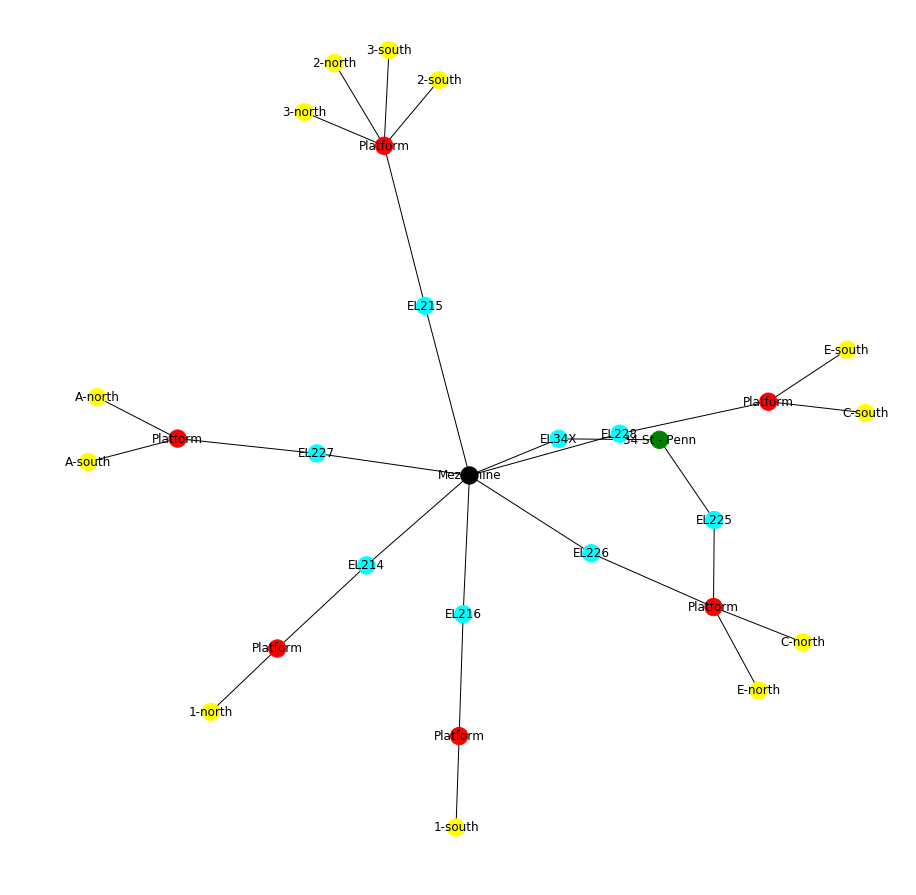

In [9]:
stations = [
#    '14 St - Union Sq',
#    '149 St - 3 Av',
#    'Simpson St',
#    '42 St - Port Authority Bus Terminal',
#      '125 St',
#    '86 St',
#    'World Trade Center',
    '34 St - Penn'
]

g = add_to_graph(nx.Graph(), stations)

labels={node : attrs.get('label', 'Missing') for node, attrs in g.nodes(True)}
color_map = {'Street' : 'green', 'Elevator' : 'cyan', 'Platform' : 'red', 'Train' : 'yellow'}
colors=[color_map.get(attrs.get('node_type', 'Missing'), 'black') for _, attrs in g.nodes(True)]
plt.figure(figsize=(12,12)) 
nx.draw(g, with_labels=True, labels=labels, node_color=colors)


In [10]:
g = add_to_graph(nx.Graph(), None)
nx.write_graphml(g, DATA_DIR+'data/processed/mta-elevators.graphml')

# Debugging cells

In [11]:
elevators[(elevators['from'] == 'Unknown') | (elevators['to'] == 'Unknown')]

,connection_to_street,description,equipment_id,from,platform_id,station_name,to,fqn_from,fqn_to,label_from,label_to
126,N,Mezzanine below 4th Ave & Pacific St (from whi...,EL304,Street,NaN,Atlantic Av-Barclays Ctr,Unknown,Street-Atlantic Av-Barclays Ctr,Unknown-Atlantic Av-Barclays Ctr,Atlantic Av-Barclays Ctr,Unknown
137,N,Plaza south of Bowling Green Park for service ...,EL710,Street,NaN,Bowling Green,Unknown,Street-Bowling Green,Unknown-Bowling Green,Bowling Green,Unknown
160,N,ADA access to the N line Platform in combinati...,EL702,Unknown,N-south/N-north,Coney Island Stillwell Av,Platform,Unknown-Coney Island Stillwell Av,Platform-Coney Island Stillwell Av-N-south/N-n...,Unknown,Platform
161,N,ADA access to the N line Platform in combinati...,EL701,Unknown,N-north/N-south,Coney Island Stillwell Av,Platform,Unknown-Coney Island Stillwell Av,Platform-Coney Island Stillwell Av-N-north/N-s...,Unknown,Platform
176,Y,Dekalb Ave & Flatbush Ave (SW corner) and Mezz...,EL370,Street,NaN,Dekalb Av,Unknown,Street-Dekalb Av,Unknown-Dekalb Av,Dekalb Av,Unknown
199,N,Fulton St & Franklin Ave (SW corner) to transf...,EL339,Street,NaN,Franklin Av,Unknown,Street-Franklin Av,Unknown-Franklin Av,Franklin Av,Unknown
205,N,Mezzanine and A/C Platforms and downtown J/Z s...,EL721,Platform,C-south/A-south/C-north/A-north,Fulton St,Unknown,Platform-Fulton St-C-south/A-south/C-north/A-n...,Unknown-Fulton St,Platform,Unknown
210,Y,Street-level of Transit Center to Upper retail...,EL733X,Street,NaN,Fulton St,Unknown,Street-Fulton St,Unknown-Fulton St,Fulton St,Unknown
251,N,Lexington Ave entrance and F/Q Platform for se...,EL402,Platform,F-south/F-north/Q-south/Q-north,Lexington Av / 63 St,Unknown,Platform-Lexington Av / 63 St-F-south/F-north/...,Unknown-Lexington Av / 63 St,Platform,Unknown
297,N,W 3rd St & 6th Ave (NE corner) to turnstiles f...,EL333,Street,NaN,West 4 St - Washington Sq,Unknown,Street-West 4 St - Washington Sq,Unknown-West 4 St - Washington Sq,West 4 St - Washington Sq,Unknown


In [12]:
raw_elevators = pd.read_csv(DATA_DIR+'data/interim/crosswalks/EE_master_list.csv')
raw_elevators = raw_elevators[ (raw_elevators.equipment_type == 'EL') ] # & (raw_elevators.ada_compliant == 'Y')
list(raw_elevators[raw_elevators['station_name'] == 'WTC Cortlandt St'].description)

['Mezzanine to Northbound Platform',
 'Mezzanine to Southbound Platform',
 'Oculus Main Level  to PATH Level with access to 1 line service at WTC Cortlandt St Station',
 'Street to Southbound platform',
 'West Concourse balcony to PATH Level with access to 1 line at WTC Cortlandt St Station',
 'West Concourse balcony to West Concourse with access to 1 line at WTC Cortlandt St Station']

In [13]:
elevators[elevators['station_name'] == '34 St - Penn']

,connection_to_street,description,equipment_id,from,platform_id,station_name,to,fqn_from,fqn_to,label_from,label_to
8,NaN,NaN,EL225,Street,C-north/E-north,34 St - Penn,Platform,Street-34 St - Penn,Platform-34 St - Penn-C-north/E-north,34 St - Penn,Platform
9,NaN,NaN,EL226,Mezzanine,C-north/E-north,34 St - Penn,Platform,Mezzanine-34 St - Penn,Platform-34 St - Penn-C-north/E-north,Mezzanine,Platform
10,NaN,NaN,EL227,Mezzanine,A-north/A-south,34 St - Penn,Platform,Mezzanine-34 St - Penn,Platform-34 St - Penn-A-north/A-south,Mezzanine,Platform
11,NaN,NaN,EL228,Mezzanine,C-south/E-south,34 St - Penn,Platform,Mezzanine-34 St - Penn,Platform-34 St - Penn-C-south/E-south,Mezzanine,Platform
12,NaN,NaN,EL34X,Street,NaN,34 St - Penn,Mezzanine,Street-34 St - Penn,Mezzanine-34 St - Penn,34 St - Penn,Mezzanine
13,NaN,NaN,EL216,Mezzanine,1-south,34 St - Penn,Platform,Mezzanine-34 St - Penn,Platform-34 St - Penn-1-south,Mezzanine,Platform
14,NaN,NaN,EL215,Mezzanine,2-north/2-south/3-north/3-south,34 St - Penn,Platform,Mezzanine-34 St - Penn,Platform-34 St - Penn-2-north/2-south/3-north/...,Mezzanine,Platform
15,NaN,NaN,EL214,Mezzanine,1-north,34 St - Penn,Platform,Mezzanine-34 St - Penn,Platform-34 St - Penn-1-north,Mezzanine,Platform


In [14]:
elevators['station_name'] == ''

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
289    False
290    False
291    False
292    False
293    False
294    False
295    False
296    False
297    False
300    False
301    False
302    False
303    False
304    False
0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
Name: station_name, Length: 305, dtype: bool